In [1]:
from torch.utils.tensorboard import SummaryWriter

In [2]:
# ~ tensorboard --logdir=./runs

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("None of MPS or CUDA devices found.")
    device = torch.devuce("cpu")
print(f"device: {device}")

device: cuda


In [5]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [6]:
train_dl = DataLoader(train_data, batch_size=64)
test_dl = DataLoader(test_data, batch_size=64)

In [7]:
image, label = train_data[0]
channels, height, width = image.shape
input_size = channels * height * width

In [8]:
class CNN(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = self._get_flattened_size(img_height, img_width)
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _get_flattened_size(self, img_height, img_width):
        dummy_input = torch.zeros(1, 1, img_height, img_width)
        output = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        output = self.pool(F.relu(self.bn2(self.conv2(output))))
        output = self.pool(F.relu(self.bn3(self.conv3(output))))
        flattened_size = output.numel()
        return flattened_size

In [9]:
# class CNN(nn.Module):
#     def __init__(self, img_height, img_width):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)

#         self.flattened_size = self._get_flattened_size(img_height, img_width)
#         self.fc1 = nn.Linear(self.flattened_size, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, self.flattened_size)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

#     def _get_flattened_size(self, img_height, img_width):
#         """
#         This function calculates the flattened size of the tensor after passing through
#         the conv and pooling layers. It uses a dummy tensor to compute the size dynamically.
#         """
#         dummy_input = torch.zeros(1, 1, img_height, img_width)

#         output = self.pool(F.relu(self.conv1(dummy_input)))
#         output = self.pool(F.relu(self.conv2(output)))

#         flattened_size = output.numel()
#         return flattened_size

In [10]:
model = CNN(height, width).to(device)

In [11]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

In [12]:
from tqdm.notebook import tqdm

In [13]:
def trainloop(dataloader, model, loss_fn, optimizer, writer, epoch):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        prediction = model(X)
        loss = loss_fn(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_value:>7f} [{current:>5d}/{size:>5d}]")
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size

    writer.add_scalars("Loss", {"train": avg_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": accuracy}, epoch)

    print(f"Average Training Loss for epoch {epoch}: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [14]:
def evaluate(dataloader, model, loss_fn, writer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size

    writer.add_scalars("Loss", {"test": test_loss}, epoch)
    writer.add_scalars("Accuracy", {"test": accuracy}, epoch)

    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

In [15]:
from datetime import datetime

In [16]:
writer = SummaryWriter(f"runs/fashion_mnist_experiment_improved_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
num_epochs = 10

# Example of running the training loop
for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = trainloop(train_dl, model, loss_fn, optimizer, writer, epoch)
    test_loss, test_acc = evaluate(test_dl, model, loss_fn, writer, epoch)

# Close the writer after training
writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

loss: 2.299561 [    0/60000]
loss: 2.129679 [ 6400/60000]
loss: 1.878631 [12800/60000]
loss: 1.655208 [19200/60000]
loss: 1.346486 [25600/60000]
loss: 1.199936 [32000/60000]
loss: 1.047527 [38400/60000]
loss: 0.909053 [44800/60000]
loss: 0.882807 [51200/60000]
loss: 0.808791 [57600/60000]
Average Training Loss for epoch 0: 1.3688, Accuracy: 0.6341
Test Error: 
 Accuracy: 75.7%, Avg loss: 0.777247 

loss: 0.737502 [    0/60000]
loss: 0.822213 [ 6400/60000]
loss: 0.516782 [12800/60000]
loss: 0.740065 [19200/60000]
loss: 0.672575 [25600/60000]
loss: 0.646216 [32000/60000]
loss: 0.649894 [38400/60000]
loss: 0.615225 [44800/60000]
loss: 0.623823 [51200/60000]
loss: 0.571033 [57600/60000]
Average Training Loss for epoch 1: 0.6408, Accuracy: 0.7824
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.569883 

loss: 0.478764 [    0/60000]
loss: 0.586532 [ 6400/60000]
loss: 0.350273 [12800/60000]
loss: 0.592657 [19200/60000]
loss: 0.540586 [25600/60000]
loss: 0.546527 [32000/60000]
loss: 0.523759 [38400/

In [17]:
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")

In [18]:
model = CNN(height, width)
model.load_state_dict(torch.load("fashion_mnist_cnn.pth"))

/tmp/ipykernel_13351/2690256528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fashion_mnist_cnn.pth'))


<All keys matched successfully>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
label_mappings = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

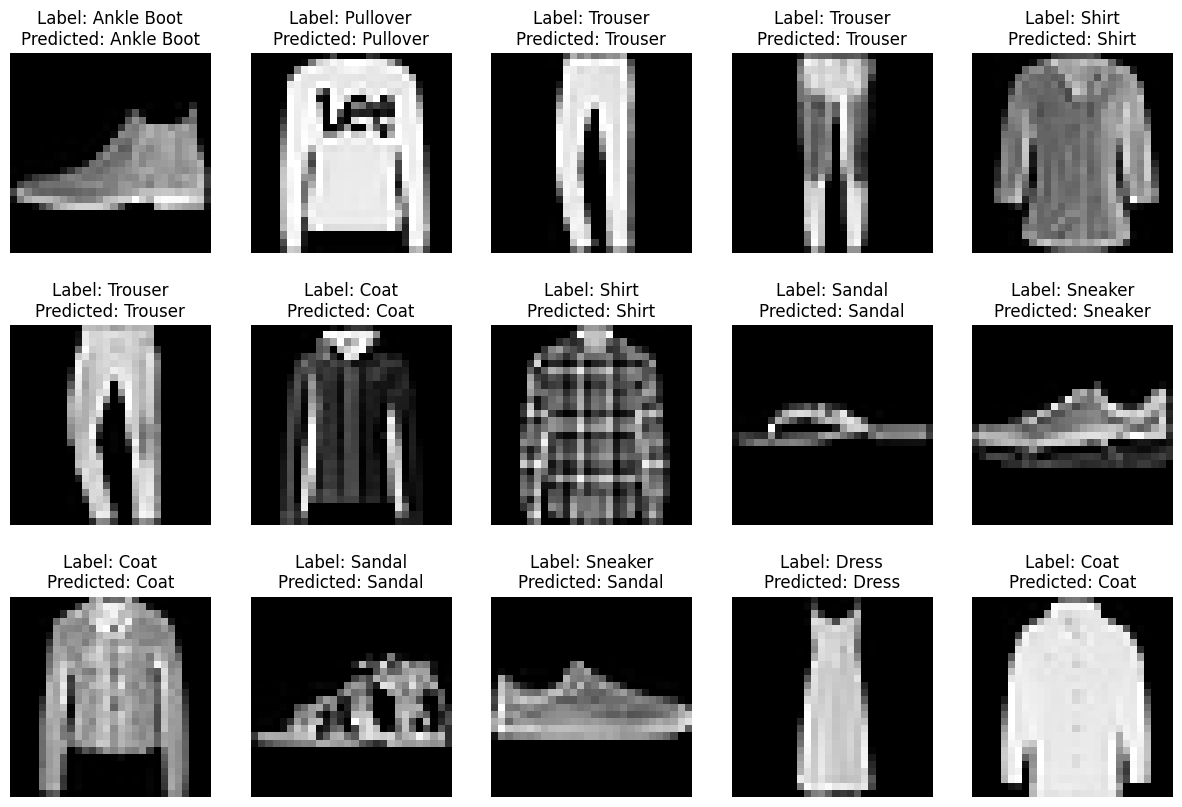

In [21]:
for X, y in test_dl:
    with torch.no_grad():
        pred = model(X)
        fig, ax = plt.subplots(3, 5, figsize=(15, 10))
        plt.gray()
        for j in range(3):
            for i in range(5):
                ax[j][i].imshow(X.squeeze()[j * 5 + i])
                label = label_mappings[y.numpy()[j * 5 + i]]
                ax[j][i].axis("off")
                predicted_label = label_mappings[np.argmax(pred[j * 5 + i]).item()]
                ax[j][i].set_title(f"Label: {label}\nPredicted: {predicted_label}")
        plt.show()
    break